In [66]:
import numpy as np 
import pandas as pd
from sklearn.model_selection import RepeatedKFold
import matplotlib.pyplot as plt
import copy
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_predict
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
import geopandas as gpd
import os
import optuna
import joblib

In [11]:
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder

In [7]:
watershed_attributes_50 = [ 
       'DA_SQKM', 'MAXDI_EROM', 'Dam_Index', 'TOT_ELEV_MEAN', 'TOT_ELEV_MAX',
       'TOT_STREAM_SLOPE', 'TOT_MAXP6190', 'TOT_MAXWD6190', 'TOT_MINWD6190',
       'TOT_RH', 'TOT_AET', 'TOT_CWD', 'TOT_BFI', 'TOT_CONTACT', 'TOT_IEOF',
       'TOT_RECHG', 'TOT_SATOF', 'TOT_TWI', 'TOT_EWT', 'TOT_RF7100',
       'TOT_MIRAD_2012', 'TOT_FRESHWATER_WD', 'TOT_STREAMRIVER',
       'TOT_ARTIFICIAL', 'TOT_CONNECTOR', 'TOT_STRM_DENS',
       'TOT_TOTAL_ROAD_DENS', 'TOT_HGA', 'TOT_HGB', 'TOT_HGC', 'TOT_HGD',
       'TOT_SILTAVE', 'TOT_CLAYAVE', 'TOT_SANDAVE', 'TOT_KFACT',
       'TOT_KFACT_UP', 'TOT_NO10AVE', 'TOT_NO200AVE', 'TOT_OM', 'TOT_ROCKDEP',
       'TOT_BDAVE', 'TOT_WTDEP', 'TOT_SRL25AG', 'TOT_NLCD19_31',
       'TOT_NLCD19_41', 'TOT_NLCD19_43', 'TOT_NLCD19_71', 'TOT_NLCD19_81',
       'TOT_NLCD19_FOREST', 'TOT_NLCD19_WETLAND']

In [8]:
# Data
# Importing spatial info
all_data = pd.read_csv(os.path.join(os.getcwd(), 'Data','WA_50_Geospatial_PUB_Variable_0d_LSTM_Error_metrics.csv'))
reg_data = all_data[all_data['Dam_Index']>=0.1]
unreg_data = all_data[all_data['Dam_Index']<0.1]

WA_df = all_data[watershed_attributes_50]
WA_df=(WA_df-WA_df.min())/(WA_df.max()-WA_df.min()) # normalizing watershed attributes
WA_arr = WA_df.to_numpy()

In [69]:
all_data.KGE.median()

0.46

In [70]:
all_data.kappa.median()

0.24

In [6]:
all_data.kappa.median()

0.2925

## hyperparameters optimization

In [29]:
all_data['kge_kappa_categories']

0      Below median
1      Above median
2      Below median
3      Below median
4      Below median
           ...     
379    Below median
380    Below median
381    Below median
382    Below median
383    Below median
Name: kge_kappa_categories, Length: 384, dtype: object

In [31]:
X = all_data[watershed_attributes_50]  
y = all_data['kge_kappa_categories']
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

def objective(trial):

    # Define the hyperparameters to be tuned
    n_estimators = trial.suggest_int('n_estimators', 200, 500)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss'])
    min_samples_split = trial.suggest_int('min_samples_split', 5, 30)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 5, 20)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 2, 100, log=True)
    ccp_alpha = trial.suggest_float('ccp_alpha', 0.00, 0.20)
    
    #class_weight = trial.suggest_categorical('class_weight', [None, 'balanced', 'balanced_subsample'])

    # Create the RandomForestClassifier with the hyperparameters
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        criterion=criterion,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        max_leaf_nodes=max_leaf_nodes,
        ccp_alpha=ccp_alpha,
        class_weight =  {1: 1, 0: 2} # 1 is Below median and 0 is Above median
    )

   # Evaluate the classifier using stratified cross-validation
    skf = StratifiedKFold(n_splits=10)
    f1_scores = []
    confusion_matrices = []
    
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        
        f1_scores.append(f1_score(y_test, y_pred, average='macro'))
        confusion_matrices.append(confusion_matrix(y_test, y_pred))
    
    # Average F1 score
    average_f1_score = np.mean(f1_scores)
    
    return average_f1_score

# Create a study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2025-03-27 15:44:43,119] A new study created in memory with name: no-name-362dc042-24aa-4248-bfce-7cc832017eb2
[I 2025-03-27 15:44:48,492] Trial 0 finished with value: 0.5372892621305893 and parameters: {'n_estimators': 348, 'criterion': 'gini', 'min_samples_split': 19, 'min_samples_leaf': 17, 'max_features': 'log2', 'max_leaf_nodes': 19, 'ccp_alpha': 0.011807465354867763}. Best is trial 0 with value: 0.5372892621305893.
[I 2025-03-27 15:44:59,344] Trial 1 finished with value: 0.2928136713042373 and parameters: {'n_estimators': 292, 'criterion': 'log_loss', 'min_samples_split': 18, 'min_samples_leaf': 6, 'max_features': None, 'max_leaf_nodes': 2, 'ccp_alpha': 0.1547631888554826}. Best is trial 0 with value: 0.5372892621305893.
[I 2025-03-27 15:45:32,912] Trial 2 finished with value: 0.5616910375544502 and parameters: {'n_estimators': 445, 'criterion': 'log_loss', 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_features': None, 'max_leaf_nodes': 49, 'ccp_alpha': 0.04638580279006

Number of finished trials: 100
Best trial: {'n_estimators': 400, 'criterion': 'gini', 'min_samples_split': 9, 'min_samples_leaf': 7, 'max_features': None, 'max_leaf_nodes': 31, 'ccp_alpha': 0.01608947548092516}


## Model training

In [47]:
best_params = {'n_estimators': 400, 'criterion': 'gini', 'min_samples_split': 9,
 'min_samples_leaf': 7, 'max_features': None, 'max_leaf_nodes': 31,
 'ccp_alpha': 0.016,
'class_weight': {1: 1, 0: 1.5}} # 1 is Below median and 0 is Above median

# Train the final model with the best hyperparameters
#best_params = study.best_trial.params
SPRF = RandomForestClassifier(
    **best_params,
    random_state=42
)

In [48]:
X = all_data[watershed_attributes_50]  
y = all_data['kge_kappa_categories']
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# StratifiedKFold CV
skf = StratifiedKFold(n_splits=10, shuffle=True)
f1_scores = []
confusion_matrices = []

# Perform k-fold cross-validation
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    SPRF.fit(X_train, y_train)
    y_pred = SPRF.predict(X_test)
        
    f1_scores.append(f1_score(y_test, y_pred, average='macro'))
    confusion_matrices.append(confusion_matrix(y_test, y_pred))
    

print(f'Cross-Validation F1 Scores: {f1_scores}')
print(f'Average F1 Score: {np.asarray(f1_scores).mean()}')

Cross-Validation F1 Scores: [0.6153846153846154, 0.6407894736842106, 0.6585858585858586, 0.7350543478260869, 0.7246376811594203, 0.8146341463414635, 0.7490829053558328, 0.680672268907563, 0.7368421052631579, 0.7490829053558328]
Average F1 Score: 0.7104766307864041


In [49]:
np.sum(confusion_matrices, axis=0)

array([[114,  45],
       [ 64, 161]], dtype=int64)

In [50]:
row_sums = [sum(row) for row in np.sum(confusion_matrices, axis=0)]
# Normalize each row
[[round((value / row_sum), 2) for value in row] for row, row_sum in zip(np.sum(confusion_matrices, axis=0), row_sums)]

[[0.72, 0.28], [0.28, 0.72]]

In [7]:
SPRF.fit(X,y)

RandomForestClassifier(ccp_alpha=0.025507146144806626, criterion='entropy',
                       max_leaf_nodes=8, min_samples_leaf=13,
                       min_samples_split=23, n_estimators=126, random_state=42)

### testing the SPRF model at 3539 ungaged basins

In [30]:
# doing more predictions
static_atts_3539 = pd.read_csv(os.path.join(os.getcwd(), 'Data','crb_nhgf_static_inputs.csv'))
static_atts_3539['predicted_performance'] = SPRF.predict(static_atts_3539.iloc[:,1:]) # prediction
prediction_prob_of_each_class = SPRF.predict_proba(static_atts_3539.iloc[:,1:-1])
static_atts_3539['AM_prob'] = prediction_prob_of_each_class[:,0]   # above median prediction prob
static_atts_3539['BM_prob'] = prediction_prob_of_each_class[:,1]    # below median prediction prob

# adding a column about the probabilty of the predictions
static_atts_3539['prob_confidence'] = static_atts_3539.apply(lambda row: 'Likely Above Median' if row['AM_prob'] > 0.65 
                          else ('Likely Below Median' if row['BM_prob'] > 0.65 else 'Uncertain'), 
                          axis=1)

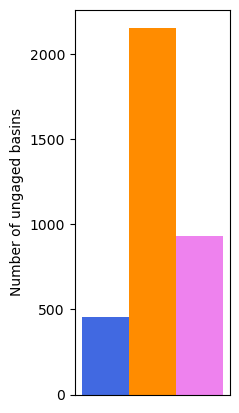

In [39]:
#static_atts_3539.plot(kind='bar', x='prob_confidence', y='Values', legend=False)
# Count the occurrences of each category
category_counts = static_atts_3539['prob_confidence'].value_counts()

# Define colors and order for the bars
colors=['royalblue', 'darkorange', 'violet']
order = ['Likely Above Median', 'Likely Below Median', 'Uncertain']  # Custom order

# Plotting the bar plot
category_counts = category_counts.reindex(order)
# Plotting the bar plot with no space between the bars and custom figure size
fig, ax = plt.subplots(figsize=(2, 5))  # Change figure size here
bars = ax.bar(category_counts.index, category_counts.values, color=colors, width=1, edgecolor='none')  # Change bar width here


# Adding custom legend
#plt.legend(bars.patches, category_counts.index, title='Projected model performance')
plt.xlabel('')
plt.ylabel('Number of ungaged basins')
plt.title('')
# Remove x-ticks
plt.xticks([])

plt.show()

In [ ]:
# adding predicted performance class to the shapefile
#shapefile_with_predicted_performance = pd.merge(gpd.read_file(os.path.join(os.getcwd(), 'Basins_shapefile', 'CO_catchments_GF1_1.shp')),
         #static_atts_3539[['nhgf_id', 'predicted_performance','AM_prob','BM_prob','prob_confidence']],
         #left_on='seg_id_nhm',
         #right_on='nhgf_id')

#shapefile_with_predicted_performance.to_file('CRB_shapefiles_with_predicted_performance.shp', driver='ESRI Shapefile')

## Orginal model

In [20]:
import shap

In [53]:
X = all_data[watershed_attributes_50]  
y = all_data['kge_kappa_categories']
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# StratifiedKFold CV
skf = StratifiedKFold(n_splits=10, shuffle=True)

best_params = {'n_estimators': 400, 'criterion': 'gini', 'min_samples_split': 9,
 'min_samples_leaf': 7, 'max_features': None, 'max_leaf_nodes': 31,
 'ccp_alpha': 0.016,
'class_weight': {1: 1, 0: 1.5}} # 1 is Below median and 0 is Above median

# Train the final model with the best hyperparameters
#best_params = study.best_trial.params
SPRF = RandomForestClassifier(
    **best_params,
    random_state=42
)

# Empty confusion matrix
cm = np.zeros((2, 2))
shap_values_list = []
test_indices_list = []
y_prediction_list = []

# Perform k-fold cross-validation
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Train RandomForestClassifier
    SPRF.fit(X_train, y_train)
    
    # Make predictions
    y_pred = SPRF.predict(X_test)
    y_prediction_list.append(y_pred)
    
    # Update confusion matrix
    cm += confusion_matrix(y_test, y_pred)

    # Initialize the SHAP explainer and calculate SHAP values
    explainer = shap.TreeExplainer(SPRF)
    shap_values = explainer.shap_values(X_test)
    shap_values_list.append(shap_values)
    test_indices_list.append(test_index)




In [54]:
cm

array([[112.,  47.],
       [ 57., 168.]])

In [55]:
row_sums = [sum(row) for row in cm]
# Normalize each row
[[round((value / row_sum), 2) for value in row] for row, row_sum in zip(cm, row_sums)]

[[0.7, 0.3], [0.25, 0.75]]

In [71]:
joblib.dump(SPRF, 'PUB_SPRF.pkl')

['PUB_SPRF.pkl']

#### Confusion matrices and bar plots

In [9]:
y = all_data['kge_kappa_categories']
cm = np.asarray([[112,  47], [ 57, 168]])

Confusion Matrix:
[[112  47]
 [ 57 168]]


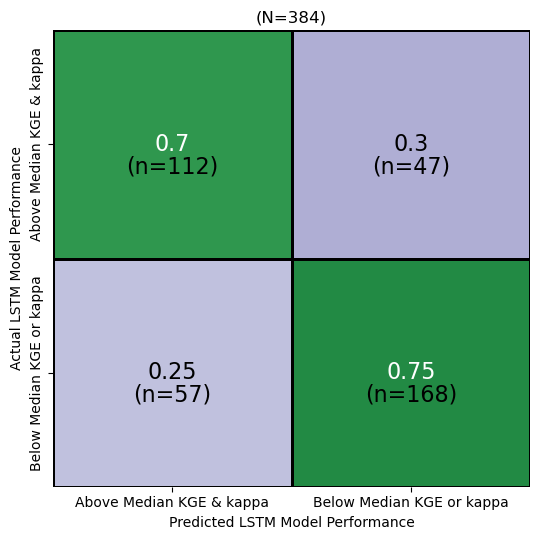

In [23]:
#VMAX = y.value_counts().max() # for cmap max value (not that important)

# train the model on all of the data
#rf_classifier.fit(X, y)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Creating a mask for true predictions
mask_true = np.eye(len(label_encoder.classes_))

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

# Creating two separate heatmaps
#fig, ax1 = plt.subplots(ncols=1, figsize=(4, 4))

# Colormap for true predictions (on diagonal)
#sns.heatmap(cm, annot=True, cmap='Greens', fmt='g',
#            cbar=False,
#            mask=~mask_true.astype(bool),  # Masking non-diagonal elements
#            xticklabels=label_encoder.classes_,
#            yticklabels=label_encoder.classes_,
 #           ax=ax1,vmin=0, vmax=VMAX)
#ax1.set_title(f'True vs Predicted model performance')

# Colormap for incorrect predictions (off diagonal)
#sns.heatmap(cm, annot=True, cmap='Reds', fmt='g',
#            cbar=False,
#            mask=mask_true.astype(bool),  # Masking diagonal elements
#            xticklabels=label_encoder.classes_,
#            yticklabels=label_encoder.classes_,
#            ax=ax1,vmin=0, vmax=VMAX)
#
#plt.xlabel('Predicted label')
#plt.ylabel('True label')
#plt.tight_layout()
#plt.show()

# range normalized confusion matrix
row_sums = [sum(row) for row in cm]
# Normalize each row
normalized_cm = [[round((value / row_sum), 2) for value in row] for row, row_sum in zip(cm, row_sums)]

# Creating two separate heatmaps
fig, ax1 = plt.subplots(ncols=1, figsize=(5.5, 5.5))

# Colormap for true predictions (on diagonal)
sns.heatmap(normalized_cm, annot=True, cmap='Greens', fmt='g',annot_kws={'color': 'white',"size": 16},
            cbar=False,
            mask=~mask_true.astype(bool),  # Masking non-diagonal elements
            xticklabels=['Above median', 'Below median'],
            yticklabels=['Above median', 'Below median'],
            linewidths = 2,
            linecolor = 'black',
            ax=ax1,vmin=0, vmax=1)
ax1.set_title(f'(N={y.shape[0]})')

# Colormap for incorrect predictions (off diagonal)
sns.heatmap(normalized_cm, annot=True, cmap='Purples', fmt='g', annot_kws={'color': 'black',"size": 16},
            cbar=False,
            mask=mask_true.astype(bool),  # Masking diagonal elements
            xticklabels=['Above Median KGE & kappa', 'Below Median KGE or kappa'],
            yticklabels=['Above Median KGE & kappa', 'Below Median KGE or kappa'],
            linewidths = 2,
            linecolor = 'black',
            ax=ax1,vmin=0, vmax=0.7)

# Manually add another annotation
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j + 0.5 , i + 0.6, f"(n={int(cm[i,j])})", color='black', ha='center', va='center',fontsize=16)

plt.xlabel('Predicted LSTM Model Performance')
plt.ylabel('Actual LSTM Model Performance')
plt.tight_layout()
plt.savefig('PUB_SPRF_RF_confmat_04072025.png', dpi=300,transparent=True)
plt.show()



NameError: name 'mask_true' is not defined

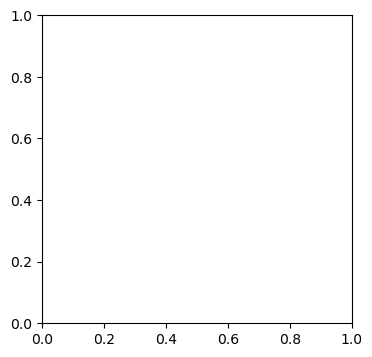

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

cm = np.asarray([[112,  47],[ 57, 168]])
# range normalized confusion matrix
row_sums = [sum(row) for row in cm]
# Normalize each row
normalized_cm = [[round((value / row_sum), 2) for value in row] for row, row_sum in zip(cm, row_sums)]

# Creating two separate heatmaps
fig, ax1 = plt.subplots(ncols=1, figsize=(4, 4))

# Colormap for true predictions (on diagonal)
sns.heatmap(normalized_cm, annot=True, cmap='Greens', fmt='g',
            cbar=False,
            mask=~mask_true.astype(bool),  # Masking non-diagonal elements
            xticklabels=['Above median', 'Below median'],
            yticklabels=['Above median', 'Below median'],
            linewidths = 2,
            linecolor = 'black',
            ax=ax1,vmin=0, vmax=1)
ax1.set_title(f'(N={y.shape[0]})')

# Colormap for incorrect predictions (off diagonal)
sns.heatmap(normalized_cm, annot=True, cmap='Purples', fmt='g', annot_kws={'color': 'black'},
            cbar=False,
            mask=mask_true.astype(bool),  # Masking diagonal elements
            xticklabels=['Above median', 'Below median'],
            yticklabels=['Above median', 'Below median'],
            linewidths = 2,
            linecolor = 'black',
            ax=ax1,vmin=0, vmax=0.7)

# Manually add another annotation
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j + 0.5 , i + 0.6, f"(n={int(cm[i,j])})", color='black', ha='center', va='center')

plt.xlabel('Predicted LSTM Model Performance')
plt.ylabel('Actual LSTM Model Performance')
plt.tight_layout()
#plt.savefig('PUB_SPRF_RF_confmat_3272025.png', dpi=300,transparent=True)
plt.show()



In [59]:
shap_values_sorted.shape

(384, 50, 2)

Class 1


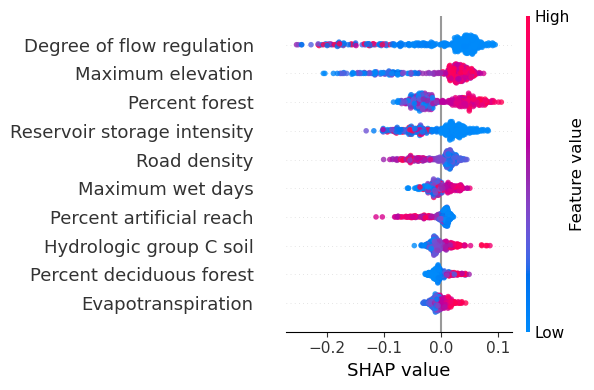

Class 2


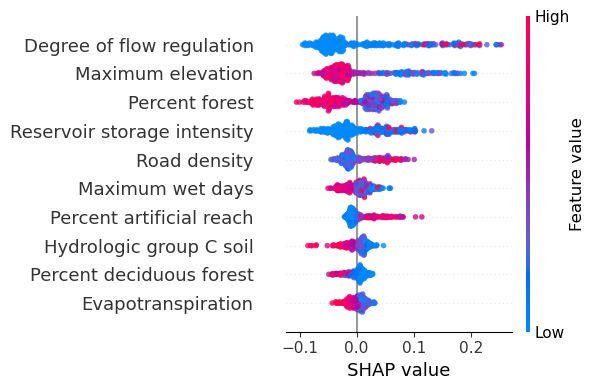

In [65]:
pr_lvl = ['Above median', 'Below median']
# Average SHAP values across folds
combined_shap_values = np.concatenate(shap_values_list, axis=0)
# Combine test indices from all folds
test_indices_combined = np.concatenate(test_indices_list, axis=0)

# Sort SHAP values and test indices by the original indices
sorted_indices = np.argsort(test_indices_combined)
shap_values_sorted = combined_shap_values[sorted_indices]

shap_values_df = pd.DataFrame(shap_values_sorted[:,:,0], columns=X.columns)

# Use the entire dataset for the combined test data
combined_X_test = X

# Visualize the combined SHAP values for each class
for i in range(2):
    print(f"Class {i + 1}")
    shap.summary_plot(shap_values_sorted[:,:,i], combined_X_test, max_display=10, plot_size=(6,4), show=False, alpha=0.8)
    #shap.plots.waterfall(shap_values_sorted[:,:,i])
    fig = plt.gcf()  # Get current figure
    ax = plt.gca()  # Get current axes

    # Adding a title
    #ax.set_title(f"SOM cluster {cluster_num} Class {pr_lvl[i]}", fontsize=15)

    # Removing the x-axis label
    ax.set_xlabel('SHAP value')
    ax.set_yticklabels(['Degree of flow regulation','Maximum elevation', 'Percent forest', 'Reservoir storage intensity', 'Road density',
                        'Maximum wet days', 'Percent artificial reach', 'Hydrologic group C soil',
                        'Percent deciduous forest', 'Evapotranspiration'][::-1])
    plt.tight_layout()
    plt.savefig(f'Shap_plot_Class_{pr_lvl[i]}_PUB_3272025.png', dpi=300, transparent=True)
    plt.show()
    

In [62]:
combined_X_test.MAXDI_EROM.max

<bound method NDFrame._add_numeric_operations.<locals>.max of 0        234.13
1        118.25
2        336.61
3          0.01
4          0.08
         ...   
379        0.61
380        1.00
381     8036.11
382    14742.26
383        0.00
Name: MAXDI_EROM, Length: 384, dtype: float64>

In [63]:
# transforming dam index and maxdi erom for better visualization
transformed_combined_X_test = copy.deepcopy(combined_X_test)
transformed_combined_X_test['MAXDI_EROM'] = np.log1p(transformed_combined_X_test['MAXDI_EROM'])
transformed_combined_X_test['Dam_Index'] = np.log1p(transformed_combined_X_test['MAXDI_EROM'])

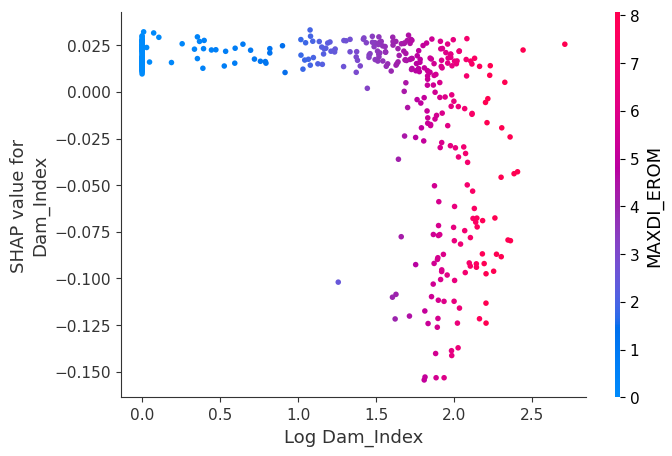

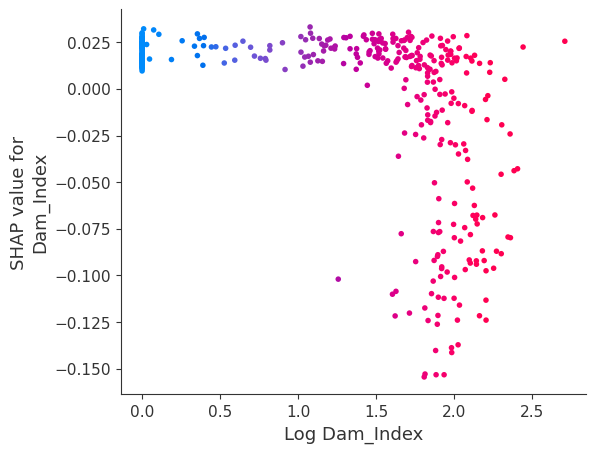

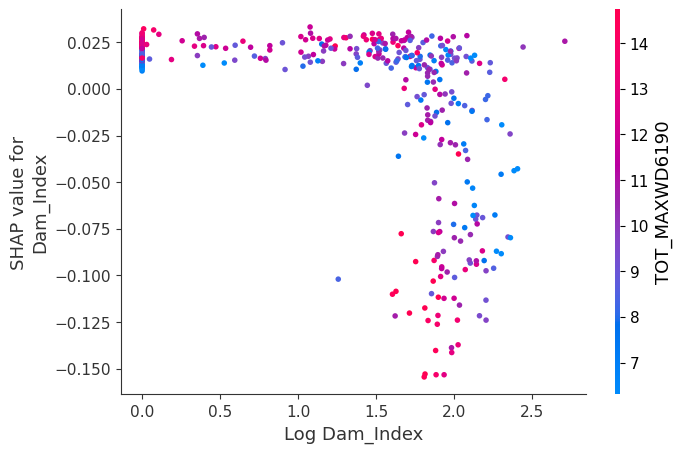

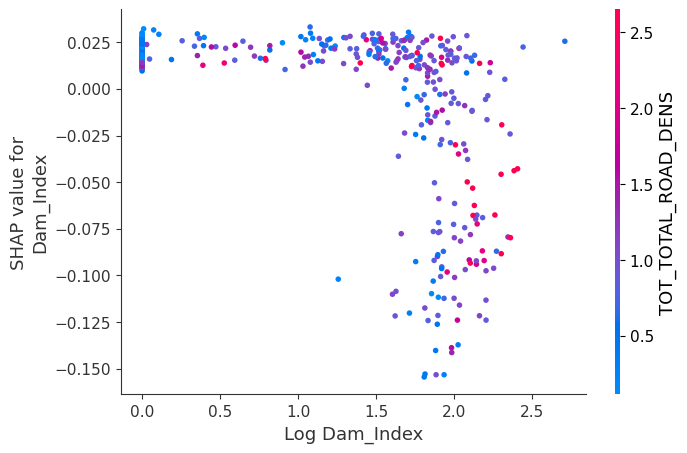

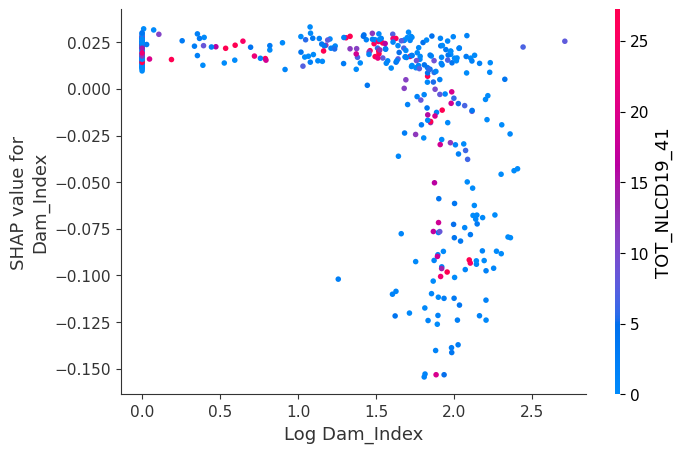

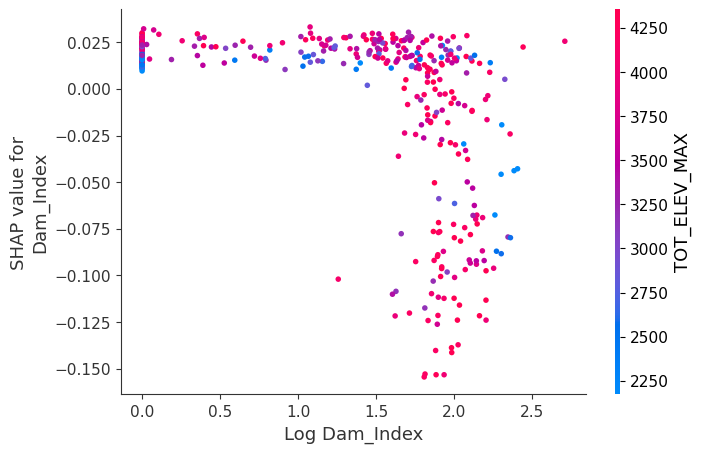

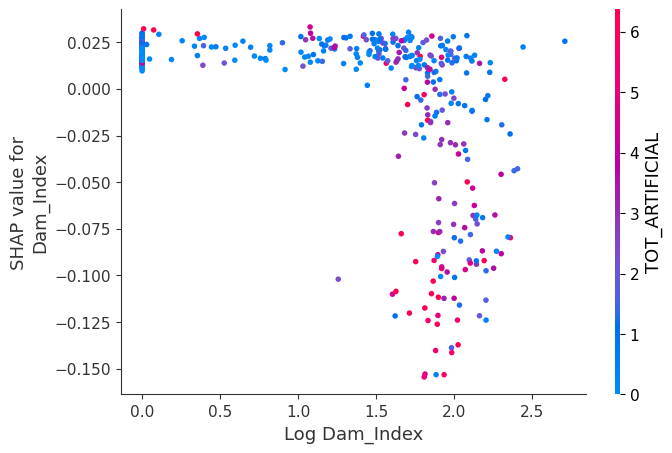

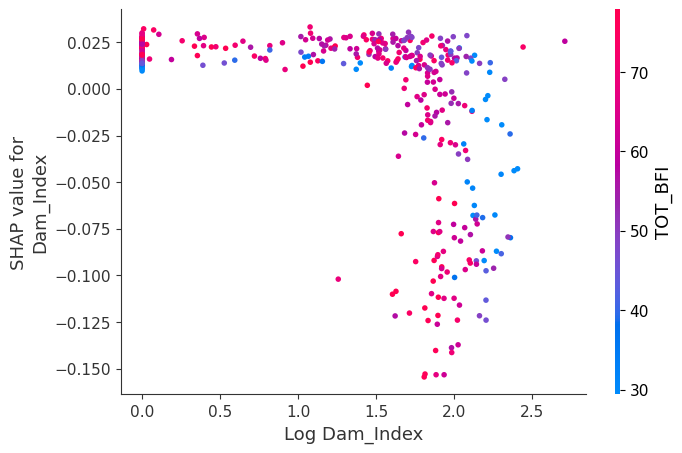

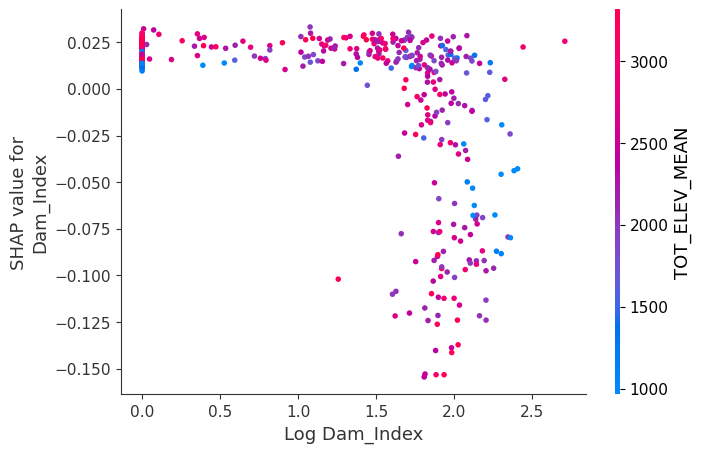

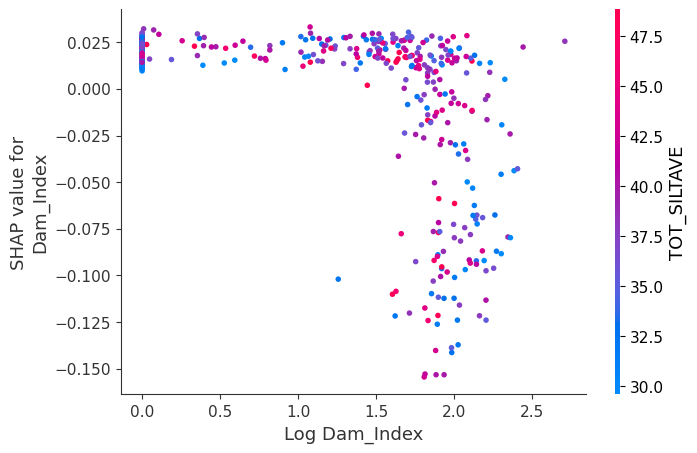

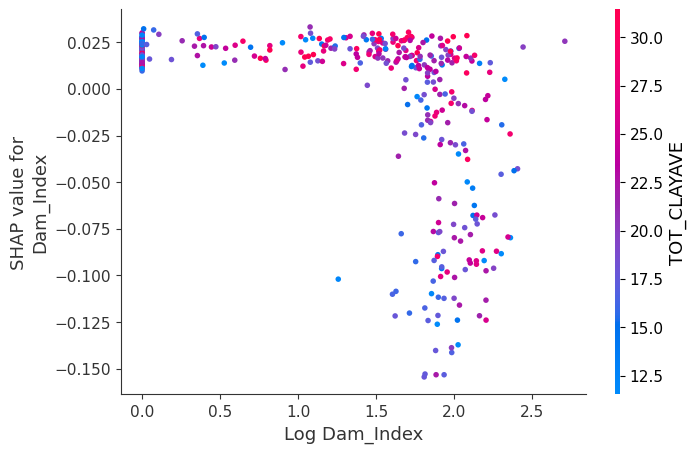

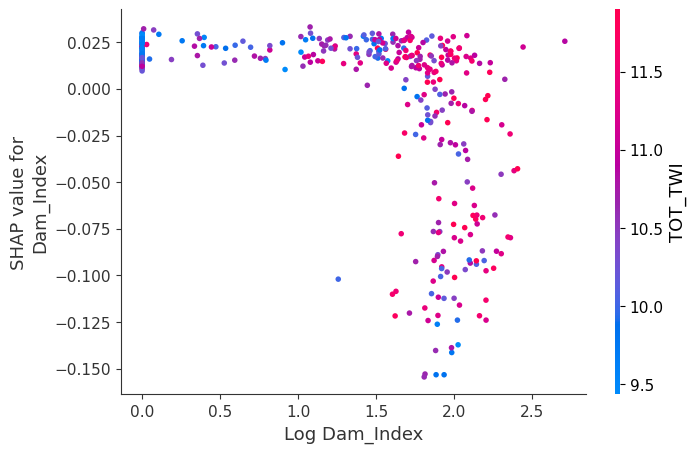

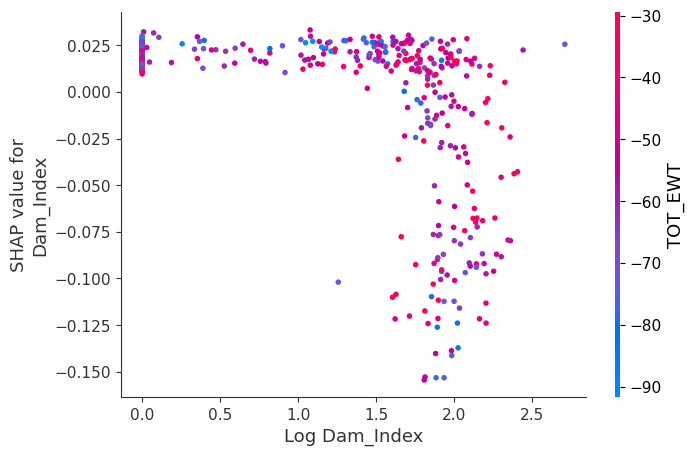

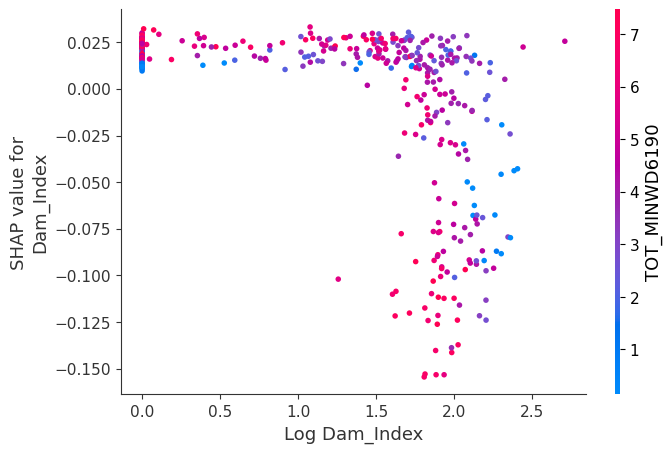

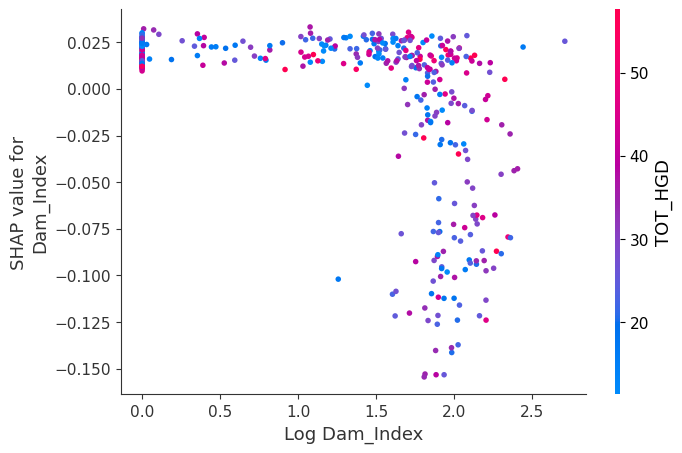

In [131]:
for intc in [1,2,7,26,44,4,23,12,3,31,32,17,18,8,30]:
    shap.dependence_plot(2, shap_values_sorted[:,:,0], transformed_combined_X_test,
                         feature_names=combined_X_test.columns, interaction_index=intc, show=False)
    fig = plt.gcf()  # Get current figure
    ax = plt.gca()
    ax.set_xlabel('Log Dam_Index')

    plt.show()

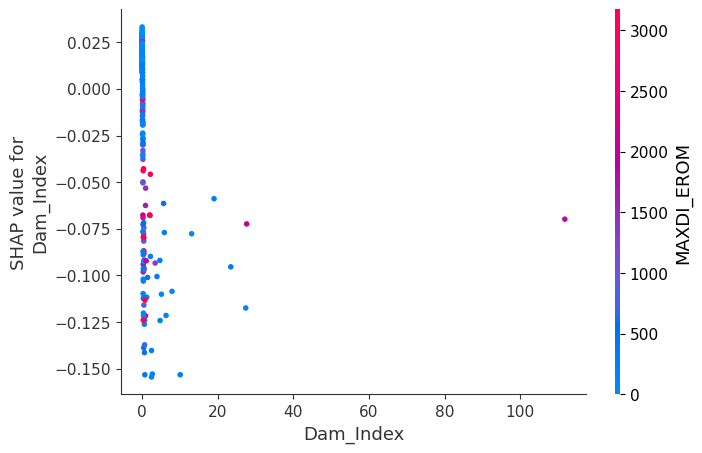

In [108]:
shap.dependence_plot(2, shap_values_sorted[:,:,0], combined_X_test, feature_names=combined_X_test.columns, interaction_index=1)

In [128]:
np.where(combined_X_test.columns=='TOT_HGD')[0][0]

30

In [56]:
combined_X_test.columns

Index(['DA_SQKM', 'MAXDI_EROM', 'Dam_Index', 'TOT_ELEV_MEAN', 'TOT_ELEV_MAX',
       'TOT_STREAM_SLOPE', 'TOT_MAXP6190', 'TOT_MAXWD6190', 'TOT_MINWD6190',
       'TOT_RH', 'TOT_AET', 'TOT_CWD', 'TOT_BFI', 'TOT_CONTACT', 'TOT_IEOF',
       'TOT_RECHG', 'TOT_SATOF', 'TOT_TWI', 'TOT_EWT', 'TOT_RF7100',
       'TOT_MIRAD_2012', 'TOT_FRESHWATER_WD', 'TOT_STREAMRIVER',
       'TOT_ARTIFICIAL', 'TOT_CONNECTOR', 'TOT_STRM_DENS',
       'TOT_TOTAL_ROAD_DENS', 'TOT_HGA', 'TOT_HGB', 'TOT_HGC', 'TOT_HGD',
       'TOT_SILTAVE', 'TOT_CLAYAVE', 'TOT_SANDAVE', 'TOT_KFACT',
       'TOT_KFACT_UP', 'TOT_NO10AVE', 'TOT_NO200AVE', 'TOT_OM', 'TOT_ROCKDEP',
       'TOT_BDAVE', 'TOT_WTDEP', 'TOT_SRL25AG', 'TOT_NLCD19_31',
       'TOT_NLCD19_41', 'TOT_NLCD19_43', 'TOT_NLCD19_71', 'TOT_NLCD19_81',
       'TOT_NLCD19_FOREST', 'TOT_NLCD19_WETLAND'],
      dtype='object')

Class 1


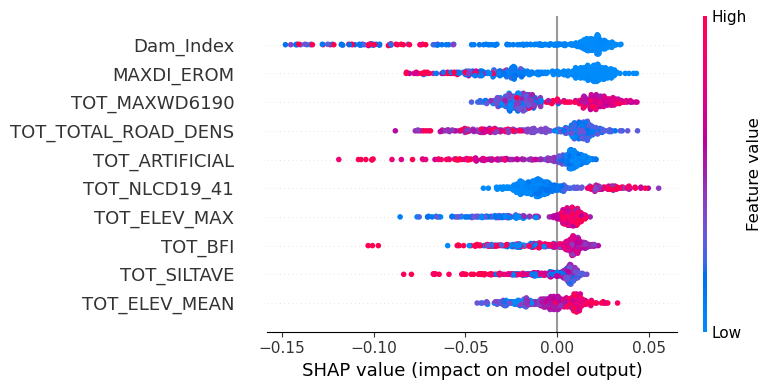

Class 2


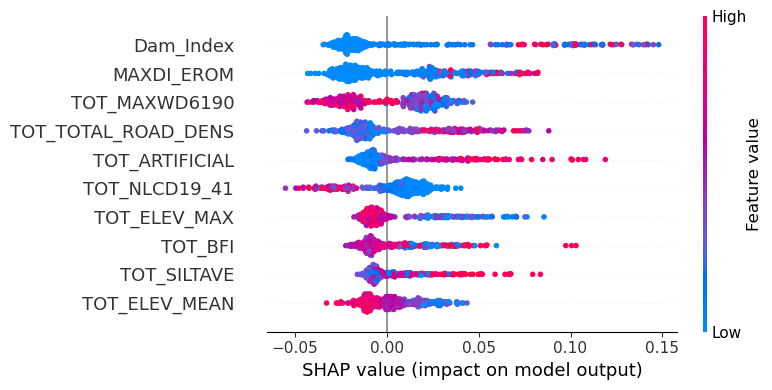

In [115]:
# Visualize the combined SHAP values for each class
for i in range(2):
    print(f"Class {i + 1}")
    shap.summary_plot(shap_values_sorted[:,:,i], combined_X_test, max_display=10, plot_size=(8,4))

In [41]:
shap_values_sorted[all_data_with_SOM[all_data_with_SOM['som_cluster']==1].index,:,0]

array([[-0.00506514,  0.01531242,  0.01845625, ...,  0.00113709,
         0.0079946 ,  0.00715538],
       [ 0.00323843,  0.00551528,  0.02228605, ..., -0.00247953,
         0.00036254, -0.00371826],
       [ 0.0009218 , -0.00646006,  0.00082438, ..., -0.0044698 ,
         0.01126352,  0.00021341],
       ...,
       [-0.00757084,  0.02201744,  0.01669415, ...,  0.00183243,
         0.00375821, -0.00388123],
       [-0.00353608,  0.01797415,  0.0200708 , ...,  0.00170005,
        -0.01065069, -0.0006473 ],
       [-0.00020981,  0.02336805,  0.02297588, ..., -0.00026349,
         0.00120541, -0.00850361]])

#### Plot shap values cluster by cluster

In [29]:
# Load the DATA
SOM_data = pd.read_csv(os.path.join('Data','WA_with_som_cluster_384_50_7_finalized.csv'))
SOMTimeS_data = pd.read_csv(os.path.join('Data','somtimes_clusters_376_8_finalized.csv'))

# Fixing the issue of not having some of the columns
SOMTimeS_data = pd.merge(SOMTimeS_data, SOM_data[['StaID','TOT_NLCD19_FOREST', 'TOT_NLCD19_WETLAND']], on='StaID')

##### SOM

In [37]:
all_data_with_SOM = pd.merge(all_data, SOM_data[['StaID','som_cluster']], on='StaID')

In [62]:
pr_lvl = ['Above median', 'Below median']

Plot for SOM cluster 1 Class Above median


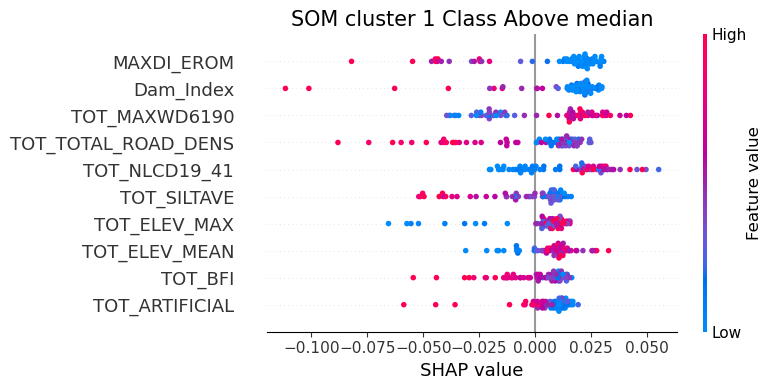

Plot for SOM cluster 1 Class Below median


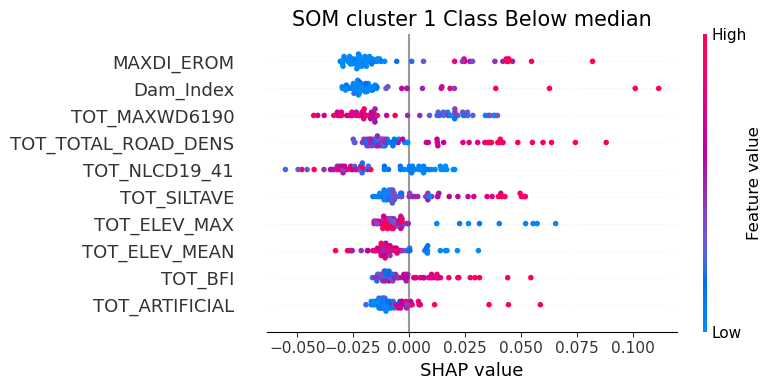

Plot for SOM cluster 2 Class Above median


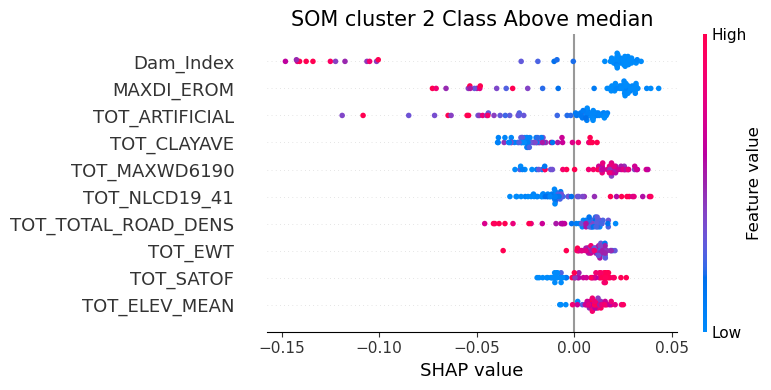

Plot for SOM cluster 2 Class Below median


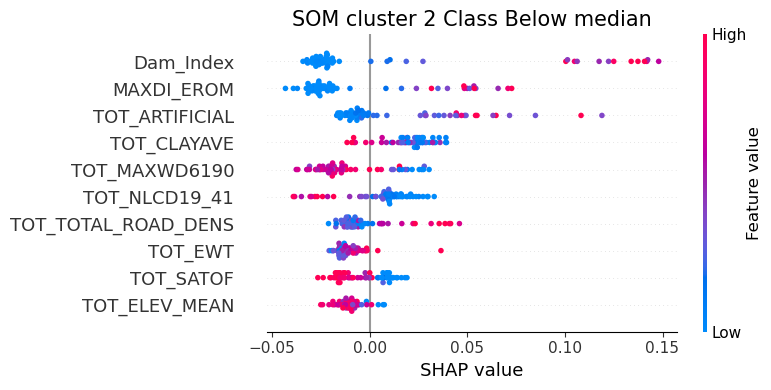

Plot for SOM cluster 3 Class Above median


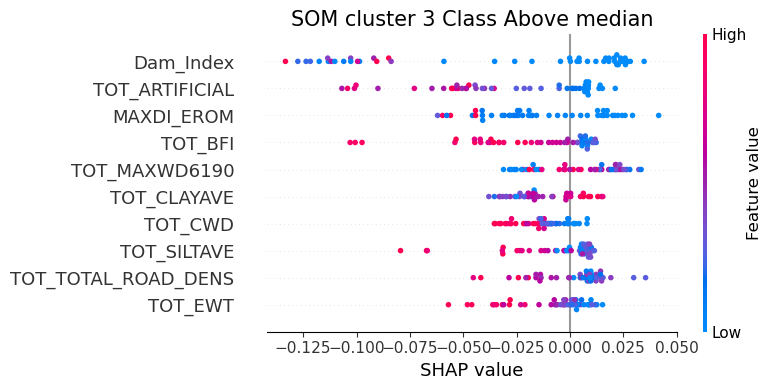

Plot for SOM cluster 3 Class Below median


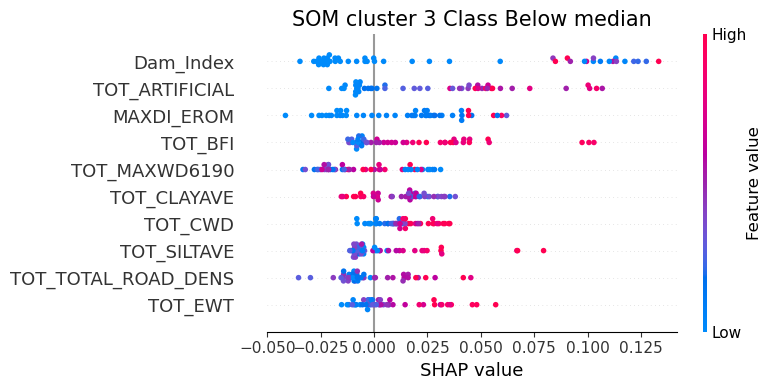

Plot for SOM cluster 4 Class Above median


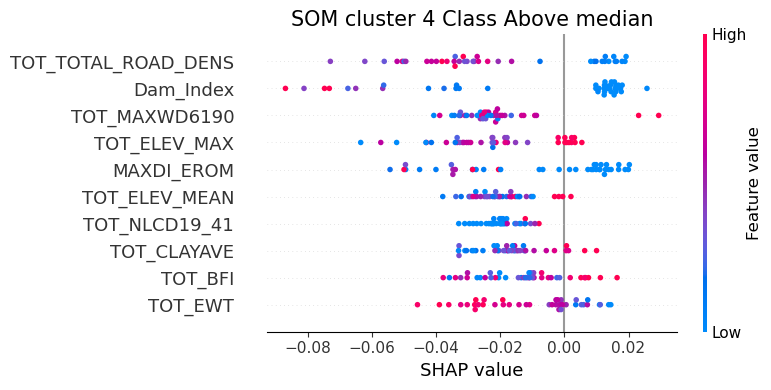

Plot for SOM cluster 4 Class Below median


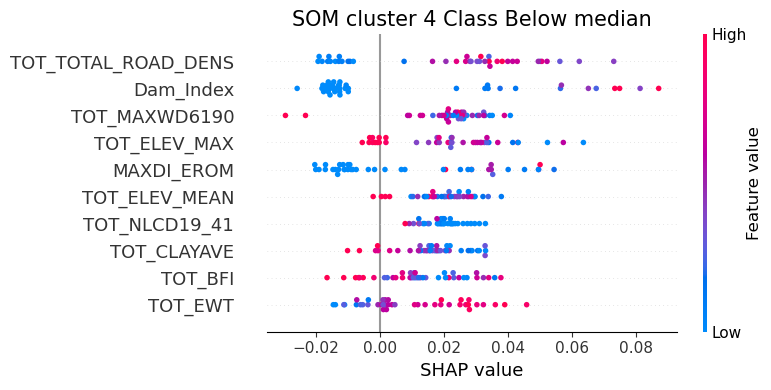

Plot for SOM cluster 5 Class Above median


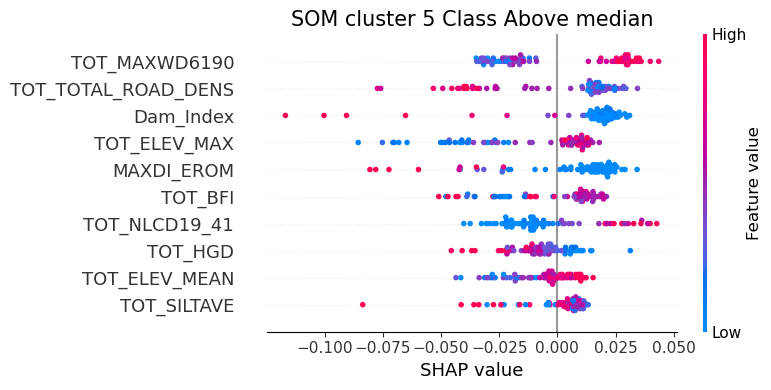

Plot for SOM cluster 5 Class Below median


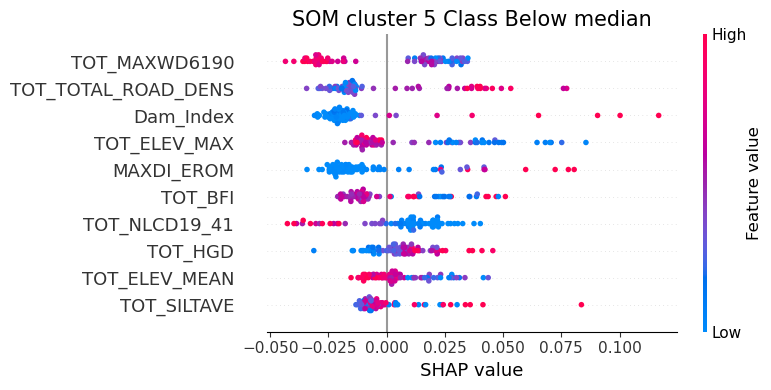

Plot for SOM cluster 6 Class Above median


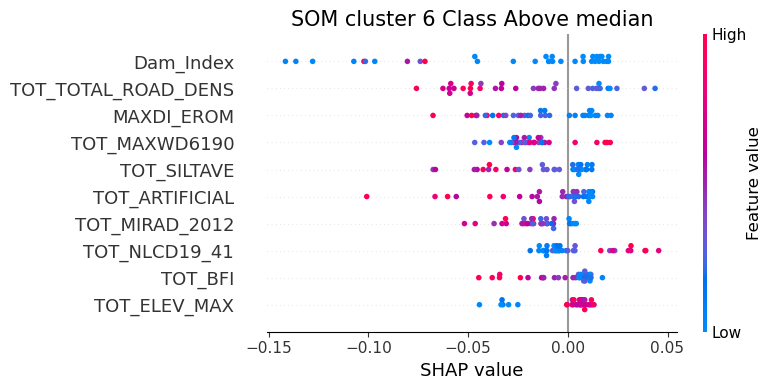

Plot for SOM cluster 6 Class Below median


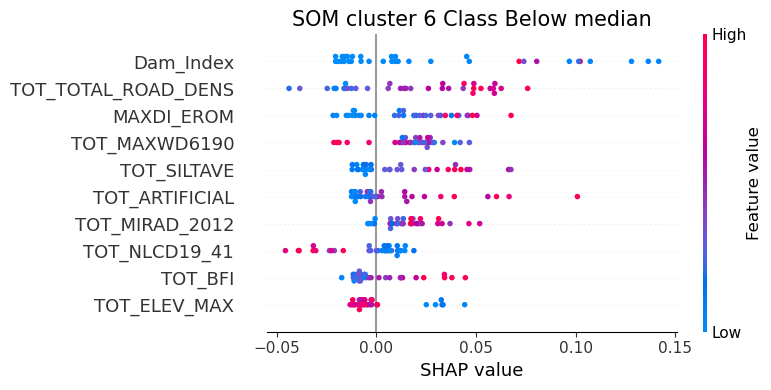

Plot for SOM cluster 7 Class Above median


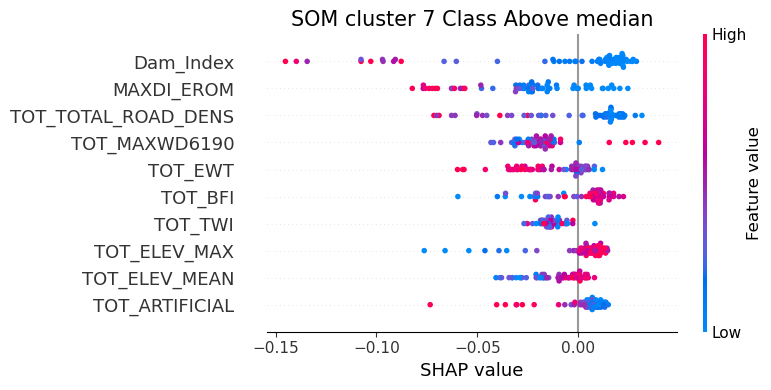

Plot for SOM cluster 7 Class Below median


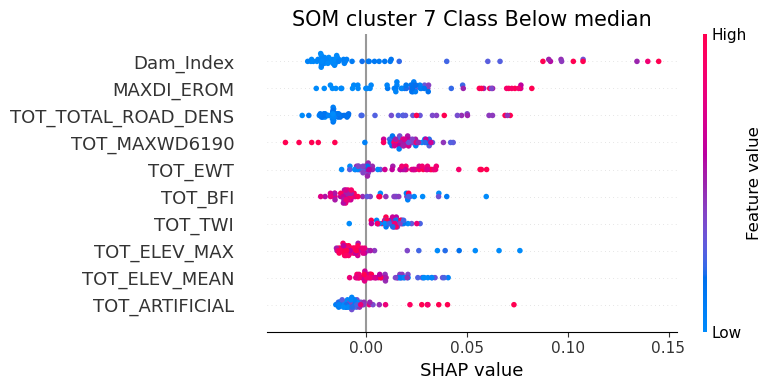

In [114]:
for cluster_num in sorted(all_data_with_SOM['som_cluster'].unique().tolist()):
    cluster_df = all_data_with_SOM[all_data_with_SOM['som_cluster']==cluster_num]
    cluster_idx = cluster_df.index
    for i in range(2):
        print(f"Plot for SOM cluster {cluster_num} Class {pr_lvl[i]}")
        shap.summary_plot(shap_values_sorted[cluster_idx,:,i], cluster_df[watershed_attributes_50],
                          max_display=10, plot_size=(8,4), show=False)
        fig = plt.gcf()  # Get current figure
        ax = plt.gca()  # Get current axes

        # Adding a title
        ax.set_title(f"SOM cluster {cluster_num} Class {pr_lvl[i]}", fontsize=15)

        # Removing the x-axis label
        ax.set_xlabel('SHAP value')
        plt.tight_layout()
        plt.savefig(f'SOM_cluster_{cluster_num}_Class_{pr_lvl[i]}.png', dpi=300, transparent=True)
        plt.show()

In [39]:
all_data_with_SOM[all_data_with_SOM['som_cluster']==1].index

Index([ 22,  70,  72,  73,  74,  76,  78,  79,  80,  81,  82,  84,  86,  87,
        88,  90,  94,  98,  99, 140, 146, 147, 148, 151, 152, 153, 154, 157,
       158, 159, 161, 162, 166, 169, 177, 181, 182, 183, 187, 195, 199, 201,
       202, 203, 210, 216, 230, 280, 281, 283, 285, 286, 287, 288, 289, 291,
       292, 293, 294, 296, 299, 303, 304, 310, 312, 319, 366],
      dtype='int64')

##### SOMTimeS

In [43]:
all_data_with_SOMTimeS = pd.merge(all_data, SOMTimeS_data[['StaID','somtimes_cluster']], on='StaID')

Plot for SOM cluster 1 Class Above median


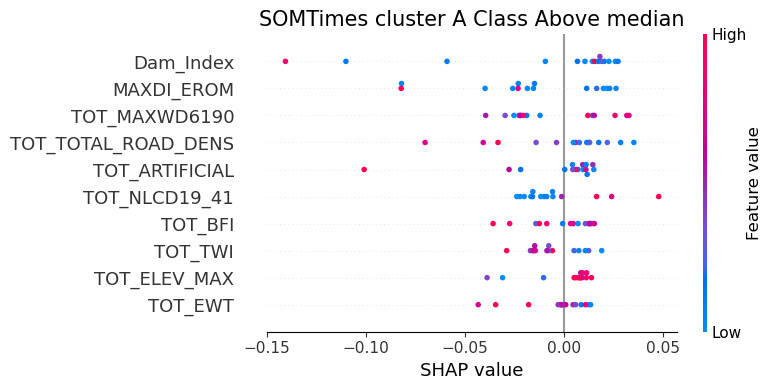

Plot for SOM cluster 1 Class Below median


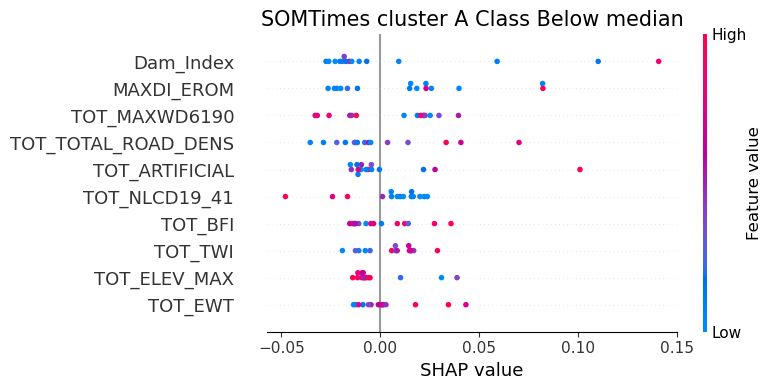

Plot for SOM cluster 2 Class Above median


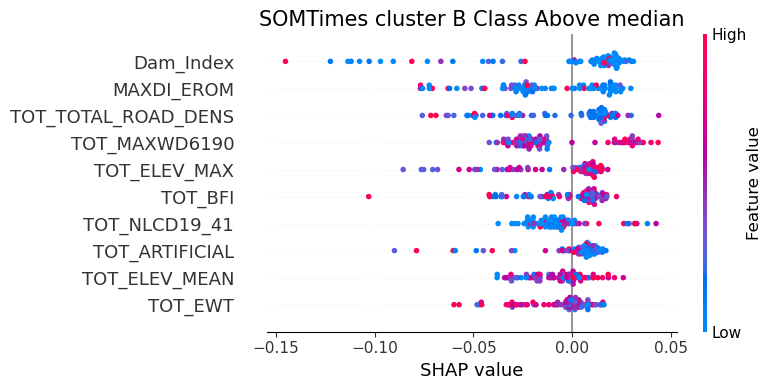

Plot for SOM cluster 2 Class Below median


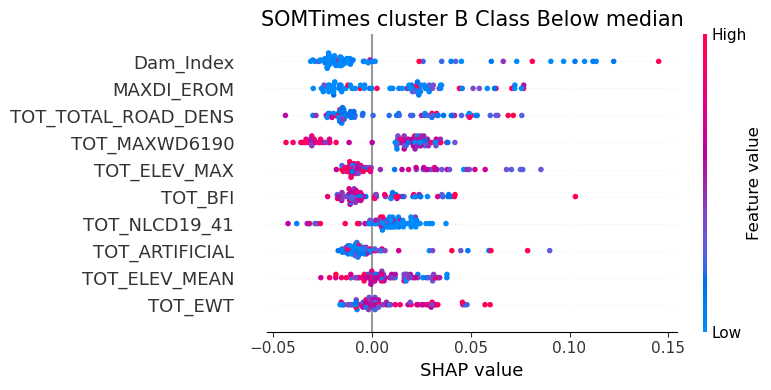

Plot for SOM cluster 3 Class Above median


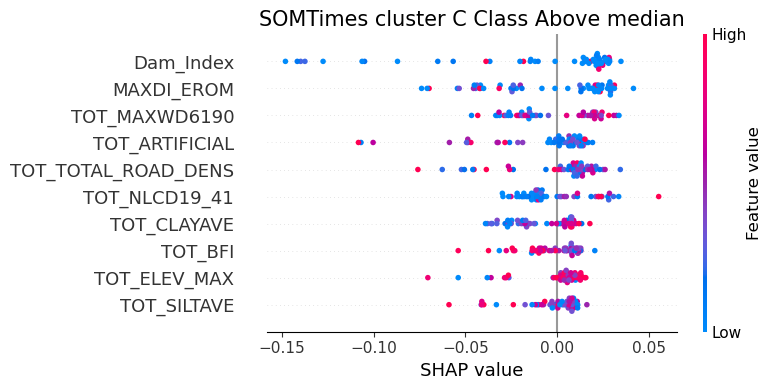

Plot for SOM cluster 3 Class Below median


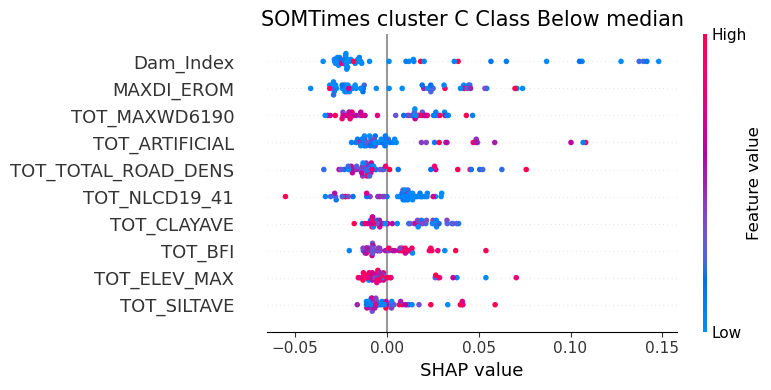

Plot for SOM cluster 4 Class Above median


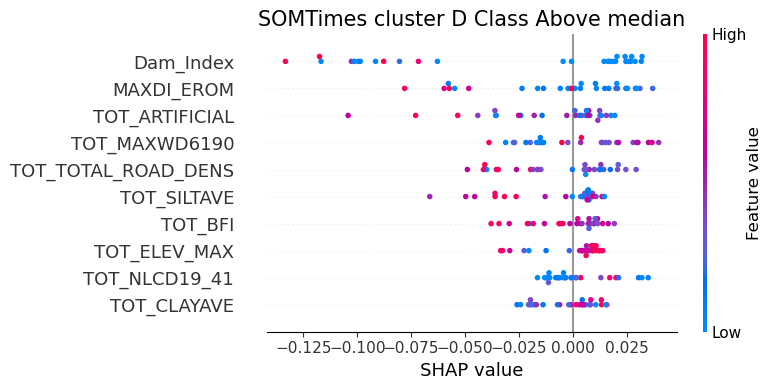

Plot for SOM cluster 4 Class Below median


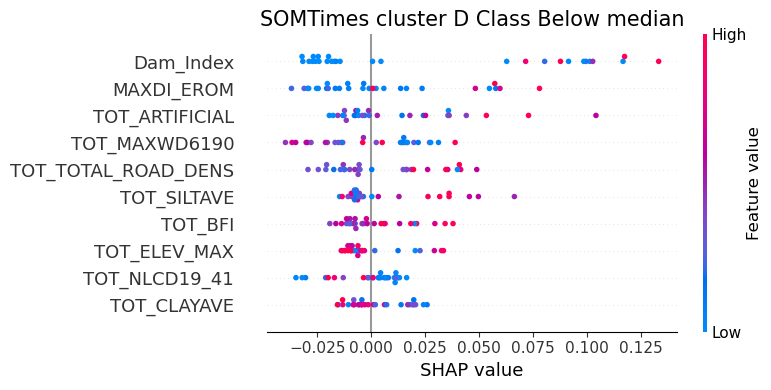

Plot for SOM cluster 5 Class Above median


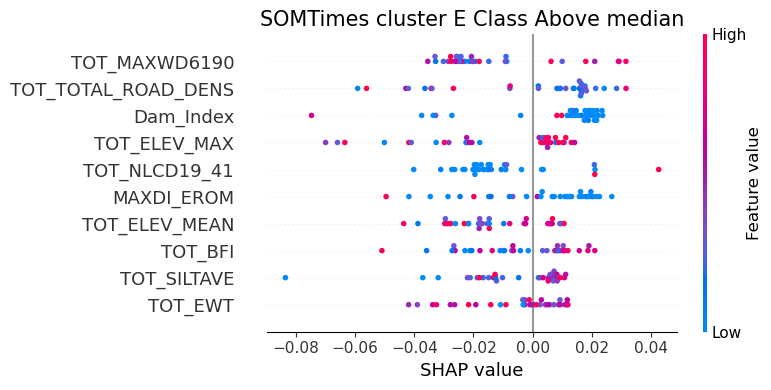

Plot for SOM cluster 5 Class Below median


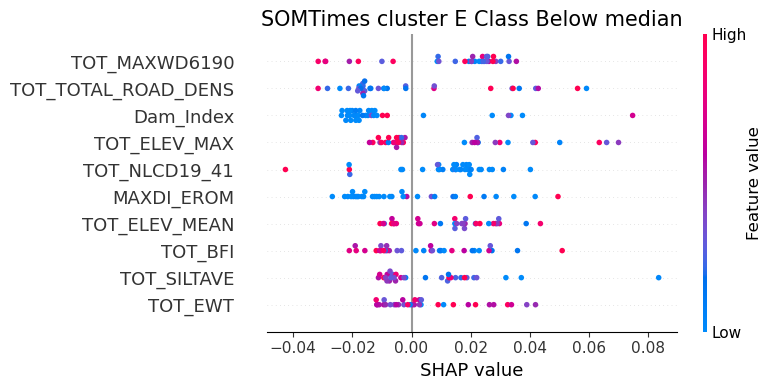

Plot for SOM cluster 6 Class Above median


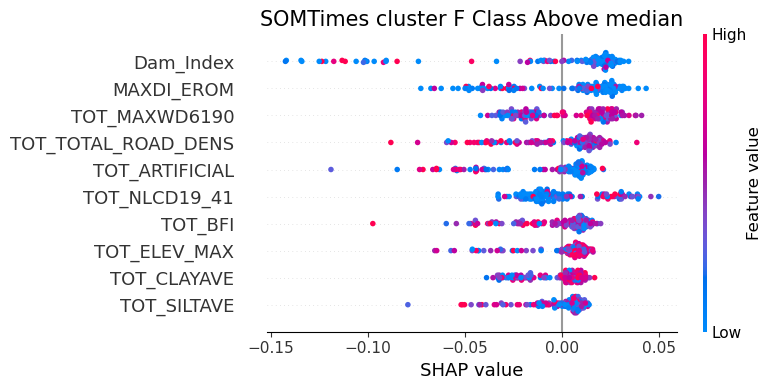

Plot for SOM cluster 6 Class Below median


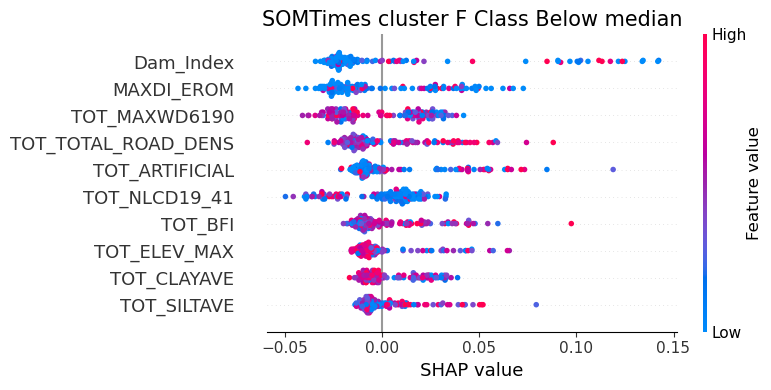

Plot for SOM cluster 7 Class Above median


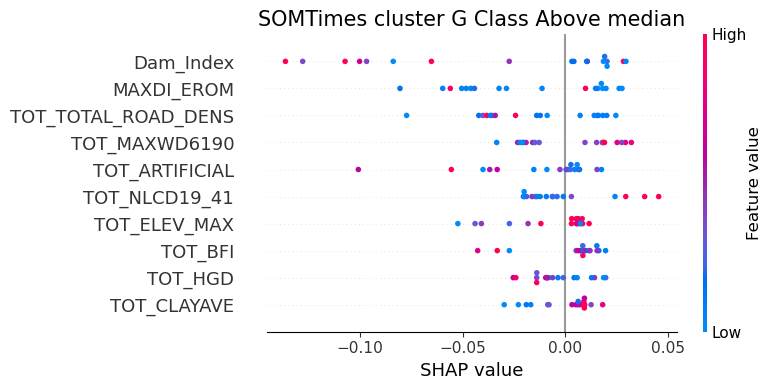

Plot for SOM cluster 7 Class Below median


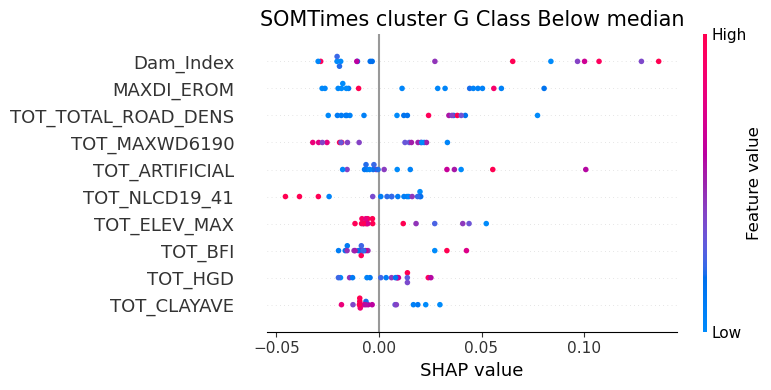

Plot for SOM cluster 8 Class Above median


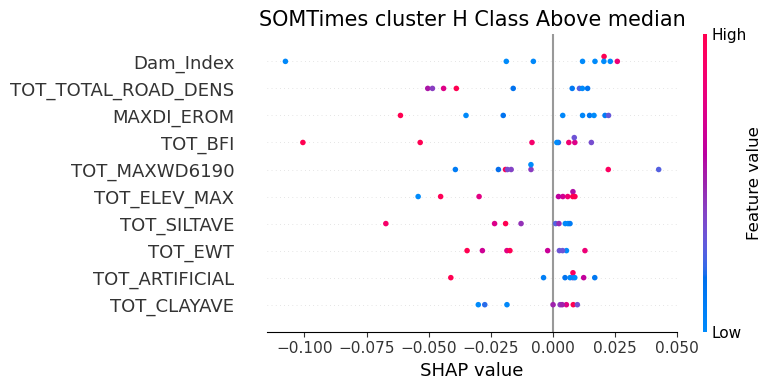

Plot for SOM cluster 8 Class Below median


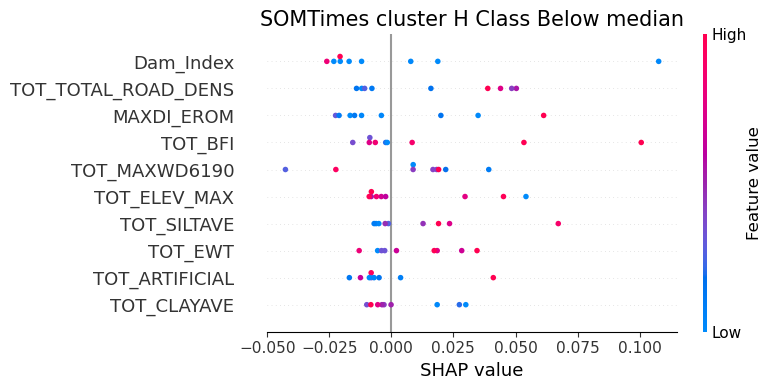

In [113]:
for cluster_num in sorted(all_data_with_SOMTimeS['somtimes_cluster'].unique().tolist()):
    cluster_df = all_data_with_SOMTimeS[all_data_with_SOMTimeS['somtimes_cluster']==cluster_num]
    cluster_idx = cluster_df.index
    for i in range(2):
        print(f"Plot for SOM cluster {cluster_num} Class {pr_lvl[i]}")
        shap.summary_plot(shap_values_sorted[cluster_idx,:,i], cluster_df[watershed_attributes_50],
                          max_display=10, plot_size=(8,4), show=False)
        fig = plt.gcf()  # Get current figure
        ax = plt.gca()  # Get current axes

        # Adding a title
        ax.set_title(f"SOMTimes cluster {chr(cluster_num+64)} Class {pr_lvl[i]}", fontsize=15)

        # Removing the x-axis label
        ax.set_xlabel('SHAP value')
        plt.tight_layout()
        plt.savefig(f'SOMTimes_cluster_{chr(cluster_num+64)}_Class_{pr_lvl[i]}.png', dpi=300, transparent=True)
        plt.show()

#### Plot confusion matrices of SPRF for SOM and SOMTimeS clusters

In [116]:
def calculate_confusion_matrices(df, cluster_col, actual_col, predicted_col):
    groups = df[cluster_col].unique()
    confusion_matrices = {}

    for group in groups:
        group_df = df[df[cluster_col] == group]
        actual = group_df[actual_col]
        predicted = group_df[predicted_col]
        cm = confusion_matrix(actual, predicted)
        confusion_matrices[group] = cm
    
    return confusion_matrices

# Function to plot confusion matrix
def plot_confusion_matrix(cm, group):
    plt.figure(figsize=(4, 2))
    sns.heatmap(cm, cbar=False, annot=True, fmt='d', cmap='Blues', xticklabels=['Above median', 'Below median'], yticklabels=['Above median', 'Below median'])
    plt.title(f'Confusion Matrix for Cluster {chr(group+64)}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.savefig(f'CM_SOMTimeS_cluster{chr(group+64)}.png', dpi=300)
    plt.show()

In [21]:
# Average SHAP values across folds
combined_y_prediction_list = np.concatenate(y_prediction_list, axis=0)
# Combine test indices from all folds
test_indices_combined = np.concatenate(test_indices_list, axis=0)

# Sort SHAP values and test indices by the original indices
sorted_indices = np.argsort(test_indices_combined)
y_prediction_list_sorted = combined_y_prediction_list[sorted_indices]

all_data['Predicted_median_categories'] = y_prediction_list_sorted

all_data_with_SOM = pd.merge(all_data, SOM_data[['StaID','som_cluster']], on='StaID')
all_data_with_SOMTimeS = pd.merge(all_data, SOMTimeS_data[['StaID','somtimes_cluster']], on='StaID')

##### SOM

In [119]:
confusion_matrices = calculate_confusion_matrices(all_data_with_SOM,
                                                  cluster_col='som_cluster',
                                                  actual_col='median_categories',
                                                  predicted_col='Predicted_median_categories')

In [120]:
for group, cm in confusion_matrices.items():
    TN, FP, FN, TP = cm.ravel()

    precision_0 = TP / (TP + FP)
    recall_0 = TP / (TP + FN)
    f1_0 = 2 * (precision_0 * recall_0) / (precision_0 + recall_0)

    precision_1 = TN / (TN + FN)
    recall_1 = TN / (TN + FP)
    f1_1 = 2 * (precision_1 * recall_1) / (precision_1 + recall_1)

    # Calculate macro F1 score
    macro_f1 = (f1_0 + f1_1) / 2

    print(f'Cluster {group} F1_score: {macro_f1}')

Cluster 3 F1_score: 0.5682792406613595
Cluster 2 F1_score: 0.6139860139860138
Cluster 6 F1_score: 0.5913461538461539
Cluster 7 F1_score: 0.6964504283965729
Cluster 1 F1_score: 0.7089189879887554
Cluster 4 F1_score: nan
Cluster 5 F1_score: 0.7698920797512347


C:\Users\adadkhah\AppData\Local\Temp\ipykernel_10088\3953859113.py:8: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_1 = TN / (TN + FN)


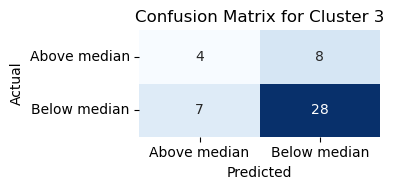

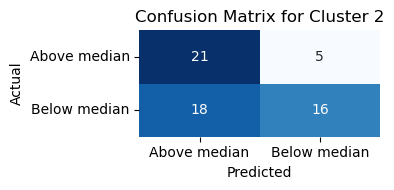

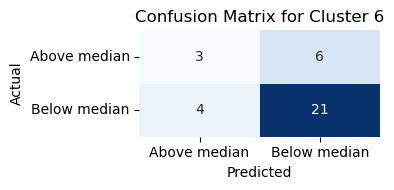

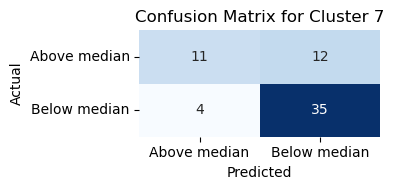

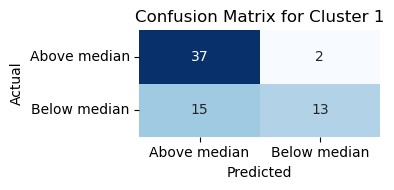

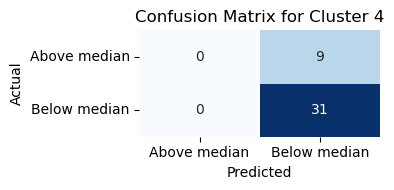

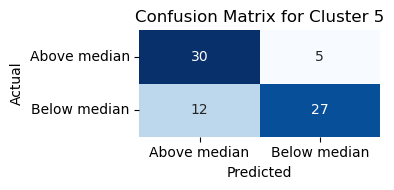

In [112]:
for group, cm in confusion_matrices.items():
    plot_confusion_matrix(cm, group)

##### SOMTimeS

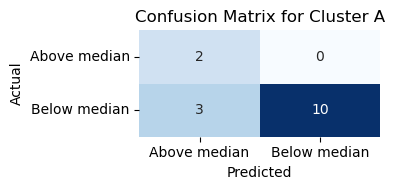

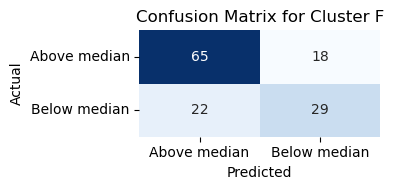

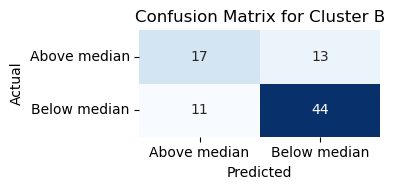

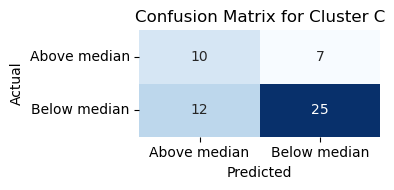

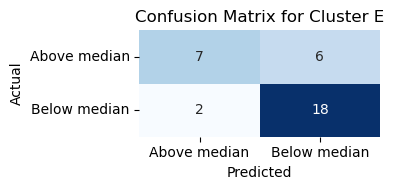

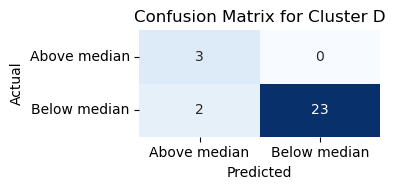

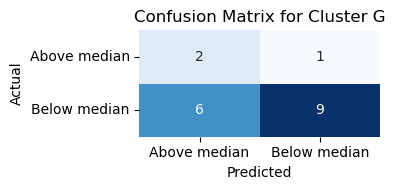

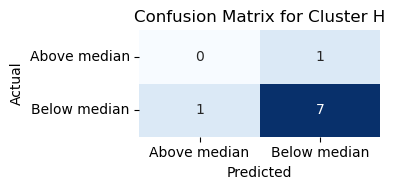

In [117]:
confusion_matrices = calculate_confusion_matrices(all_data_with_SOMTimeS,
                                                  cluster_col='somtimes_cluster',
                                                  actual_col='median_categories',
                                                  predicted_col='Predicted_median_categories')

for group, cm in confusion_matrices.items():
    plot_confusion_matrix(cm, group)

#### Upper & Lower basins

Gages in huc04 of 13, 15 or 18 are counted as lower CRB and else upper CRB

In [22]:
all_data['HUC08'] = all_data['HUC08'].astype(str)

In [28]:
Lower_df = all_data[all_data['HUC08'].str[:2].isin(['15', '18'])]
Upper_df = all_data[all_data['HUC08'].str[:2].isin(['14'])]

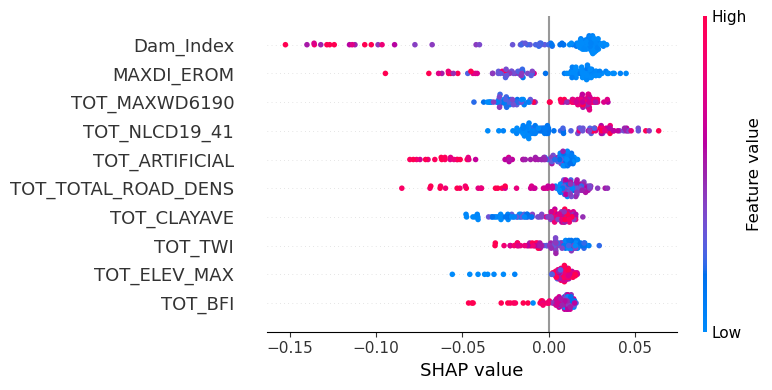

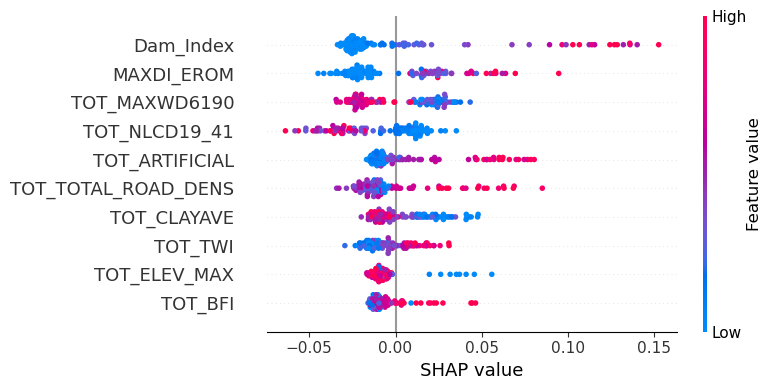

In [29]:
cluster_df = Upper_df
cluster_idx = cluster_df.index
for i in range(2):
    #print(f"Plot for SOM cluster {cluster_num} Class {pr_lvl[i]}")
    shap.summary_plot(shap_values_sorted[cluster_idx,:,i], cluster_df[watershed_attributes_50],
                          max_display=10, plot_size=(8,4), show=False)
    fig = plt.gcf()  # Get current figure
    ax = plt.gca()  # Get current axes

    # Adding a title
    #ax.set_title(f"SOM cluster {cluster_num} Class {pr_lvl[i]}", fontsize=15)

    # Removing the x-axis label
    ax.set_xlabel('SHAP value')
    plt.tight_layout()
    #plt.savefig(f'SOM_cluster_{cluster_num}_Class_{pr_lvl[i]}.png', dpi=300, transparent=True)
    plt.show()

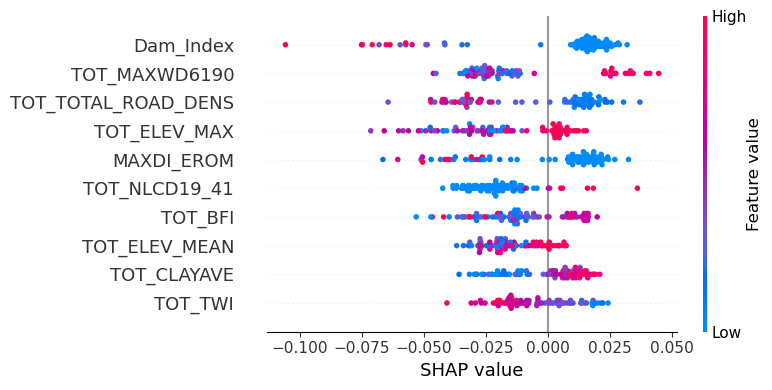

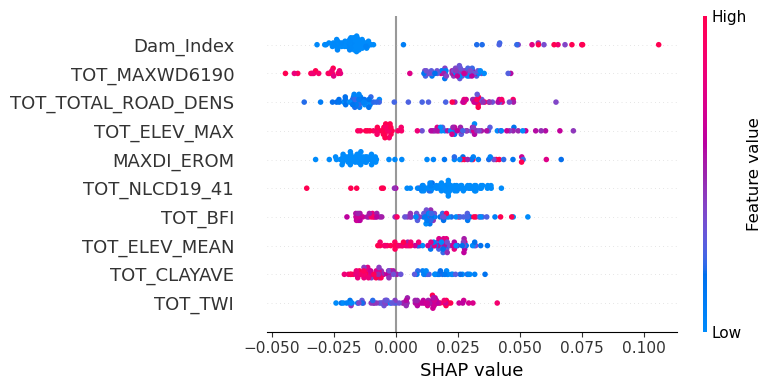

In [30]:
cluster_df = Lower_df
cluster_idx = cluster_df.index
for i in range(2):
    #print(f"Plot for SOM cluster {cluster_num} Class {pr_lvl[i]}")
    shap.summary_plot(shap_values_sorted[cluster_idx,:,i], cluster_df[watershed_attributes_50],
                          max_display=10, plot_size=(8,4), show=False)
    fig = plt.gcf()  # Get current figure
    ax = plt.gca()  # Get current axes

    # Adding a title
    #ax.set_title(f"SOM cluster {cluster_num} Class {pr_lvl[i]}", fontsize=15)

    # Removing the x-axis label
    ax.set_xlabel('SHAP value')
    plt.tight_layout()
    #plt.savefig(f'SOM_cluster_{cluster_num}_Class_{pr_lvl[i]}.png', dpi=300, transparent=True)
    plt.show()